In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from pathlib import Path

# Agrego path de root
ROOT_PATH = str(Path.cwd().parent.parent)
if ROOT_PATH not in sys.path:
    sys.path.append(ROOT_PATH)

# Path de las imagenes
IMG_DATA_PATH = Path(ROOT_PATH + "/data/raw/images/all")

# Importo e instancio ImagePreprocessor y Segmentator
from src.vision.preprocessor import ImagePreprocessor
from src.vision.segmentator import Segmentator

In [5]:
def get_random_image(category, base_path="data/raw/images/all"):
    """
    Busca una imagen aleatoria de una categoría específica.
    Retorna: (path_absoluto, imagen_cv2)
    """
    dir_path = os.path.join(base_path, category)
    if not os.path.exists(dir_path):
        print(f"❌ Error: No existe el directorio {dir_path}")
        return None, None
        
    files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not files:
        print(f"⚠️ No hay imágenes en {category}")
        return None, None
        
    random_file = random.choice(files)
    full_path = os.path.join(dir_path, random_file)
    
    # Cargar imagen (OpenCV carga en BGR por defecto)
    image = cv2.imread(full_path)
    return full_path, image

In [32]:
def visualize_segmentation_pipeline():
    # 1. Configuración
    base_path = IMG_DATA_PATH
    categories = ["arandelas", "clavos", "tornillos", "tuercas"]
    
    # Colores para las máscaras (Formato RGB para Matplotlib)
    colors = [
        (255, 0, 0),   # Rojo
        (0, 255, 0),   # Verde
        (0, 0, 255),   # Azul
        (255, 255, 0), # Amarillo
        (0, 255, 255), # Cian
        (255, 0, 255)  # Magenta
    ]

    # Instanciar el Pipeline
    # Nota: Asegúrate de que los parámetros coincidan con tu mejor configuración actual
    preprocessor = ImagePreprocessor(target_size = (960,1280),
                                gamma = 1.6,
                                d_bFilter = 8,
                                binarization_block_size = 33,
                                binarization_C = -7,
                                open_kernel_size = (3, 3),
                                close_kernel_size = (5, 5),
                                clear_border_margin = 3)
    
    segmentator = Segmentator(
        min_area = 80,
        merge_distance = 30
    )

    # 2. Configurar Gráfico
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Resultado de Segmentación (BBox + Máscaras)', fontsize=16)
    axes_flat = axes.flatten()

    print("🚀 Ejecutando Pipeline de Segmentación...")

    for i, category in enumerate(categories):
        ax = axes_flat[i]
        path, raw_img_bgr = get_random_image(category, base_path)
        if raw_img_bgr is None: ax.text(0.5,0.5,"Sin img"); continue

        try:
            # A. Guardamos dimensiones ORIGINALES
            h_orig, w_orig = raw_img_bgr.shape[:2]

            # B. Procesamiento
            binary_img = preprocessor.process(raw_img_bgr) # Esto hace letterbox a 800x600
            
            seg_result = segmentator.process(binary_img)
            bboxes_proc = seg_result.get("bounding_boxes", []) # bboxes en 800x600
            masks_proc = seg_result.get("masks", [])          # máscaras en 800x600

            # C. Visualización sobre la imagen ORIGINAL
            # --- CORRECCIÓN CLAVE: Usamos la imagen original sin tocar ---
            vis_img = cv2.cvtColor(raw_img_bgr, cv2.COLOR_BGR2RGB)
            
            if not bboxes_proc:
                 cv2.putText(vis_img, "NO DETECTADO", (50, h_orig//2), 
                           cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 5)

            for idx, (bbox_p, mask_p) in enumerate(zip(bboxes_proc, masks_proc)):
                color = colors[idx % len(colors)]
                
                # --- 1. ESCALAR BBOX DE VUELTA ---
                # Usamos el nuevo método del preprocesador
                x, y, w, h = preprocessor.scale_bbox_back(bbox_p, raw_img_bgr.shape)
                
                # Dibujar BBox en espacio original
                cv2.rectangle(vis_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
                cv2.putText(vis_img, f"Obj {idx+1}", (x, y - 10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

                # --- 2. ESCALAR MÁSCARA DE VUELTA ---
                if mask_p is not None:
                    # ANTES (MAL): mask_orig = cv2.resize(mask_p, (w_orig, h_orig)...)
                    
                    # AHORA (BIEN): Usamos el método inteligente que quita el padding
                    mask_orig = preprocessor.scale_mask_back(mask_p, raw_img_bgr.shape)
                    
                    # Crear overlay
                    colored_mask = np.zeros_like(vis_img)
                    colored_mask[mask_orig > 0] = color
                    
                    vis_img = cv2.addWeighted(vis_img, 1.0, colored_mask, 0.4, 0)
                    
                    # Dibujar contorno fino para verificar precisión
                    contours, _ = cv2.findContours(mask_orig, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    cv2.drawContours(vis_img, contours, -1, color, 2)

            # D. Mostrar
            # Matplotlib ahora mostrará la imagen en su relación de aspecto original
            ax.imshow(vis_img)
            filename = os.path.basename(path)
            ax.set_title(f"{category.upper()}\n{filename}\n({w_orig}x{h_orig})", fontsize=9)
            ax.axis('off')

        except Exception as e:
            print(f"❌ Error: {e}")
            # traceback.print_exc() # Descomentar para debug

    plt.tight_layout()
    plt.show()

🚀 Ejecutando Pipeline de Segmentación...


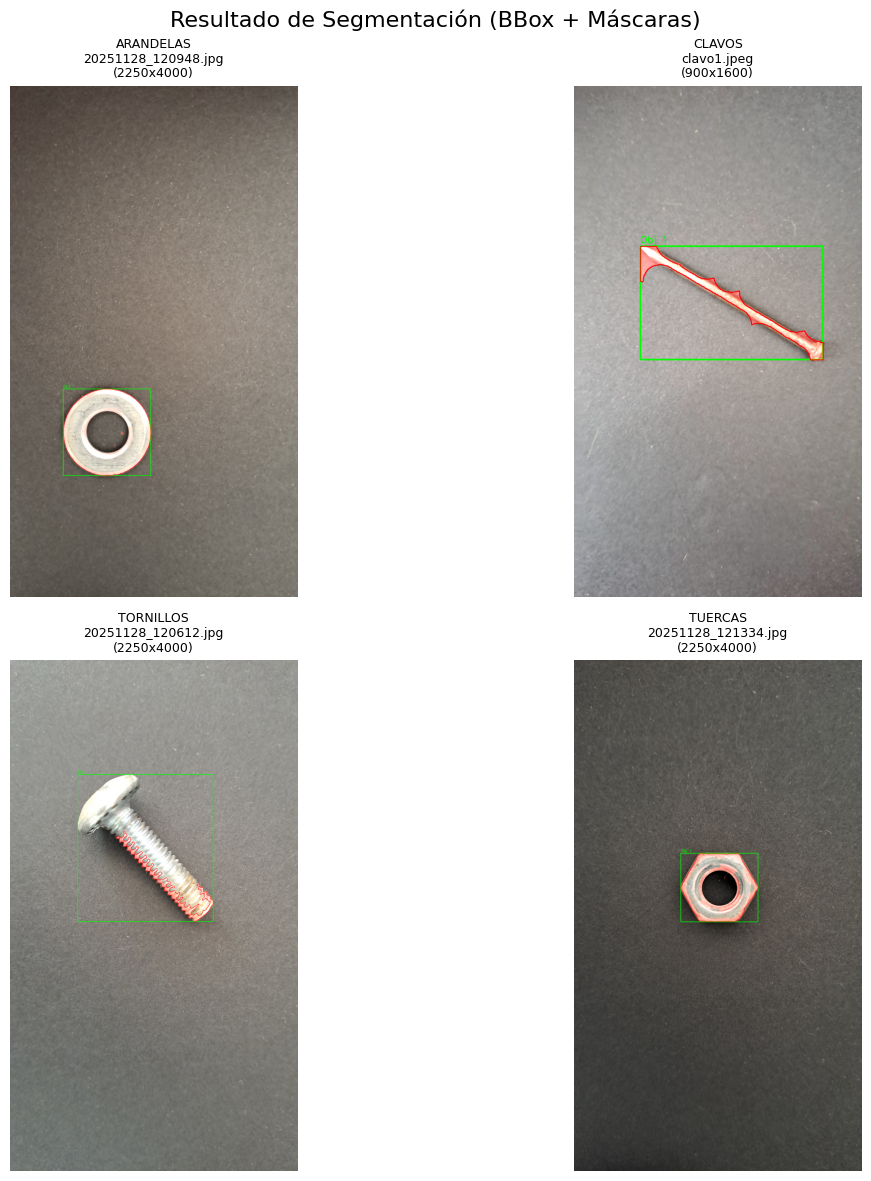

In [33]:
visualize_segmentation_pipeline()

### Multiples piezas en una imagen